In [96]:
using Pkg
Pkg.activate()
using Combinatorics, SparseArrays, KrylovKit, LinearAlgebra, Plots, LaTeXStrings
theme(:lime)

  Activating project at `C:\Users\saksh\.julia\environments\v1.7`


In [141]:
hilbert_dim(k, n) = binomial(k + n - 1, n - 1)

function generate_basis(N, L)
    if L > 1
        basis = zeros(Int16, (hilbert_dim(N, L), L))
        j = 1
    
        for n in 0:N
            d = hilbert_dim(n, L - 1)
            basis[j:(j + d - 1), 1] .= (N - n)
            basis[j:(j + d - 1), 2:end] = generate_basis(n, L - 1)
            j += d
        end
        
    else
        basis = [N]
    end

    return basis
end

generate_basis (generic function with 1 method)

In [142]:
function hop(state, i, j)
    res_state = copy(state)
    res_state[i] += 1
    res_state[j] -= 1
    return res_state
end

# tags to label the basis states
tag(state) = sum(sqrt.(100 .* (1:length(state)) .+ 3) .* state)
unzip(arr) = map(x -> getfield.(arr, x), fieldnames(eltype(arr)))

function generate_kinetic(t, basis)
    D, L = size(basis)
    basis_tags = tag.(eachslice(basis, dims = 1)) # generate tags for each basis
    inds, basis_tags = sortperm(basis_tags), sort(basis_tags) # sorting tag-list to reduce complexity

    H_kin = Dict{Tuple{Int64, Int64}, Float64}()

    for v in 1:D # iterate through basis vectors
        state = basis[v, :] # get vth basis state 

        for j in 1:L # iterate through states (hopping) 
            if state[j] > 0 
                i = mod1(j + 1, L) # Periodic BC
                u = inds[searchsortedfirst(basis_tags, tag(hop(state, i, j)))]
                H_kin[(u, v)] = get(H_kin, (u, v), 0.) - t * ((state[i] + 1) * state[j]) ^ 0.5
            
                i = mod1(j - 1, L) # Periodic BC
                u = inds[searchsortedfirst(basis_tags, tag(hop(state, i, j)))]
                H_kin[(u, v)] = get(H_kin, (u, v), 0.) - t * ((state[i] + 1) * state[j]) ^ 0.5
            end
        end
    end

    return sparse(unzip(keys(H_kin))..., collect(values(H_kin)))
end

generate_interaction(U, basis) = spdiagm(0.5 .* U .* sum(basis .* (basis .- 1), dims = 2) |> vec)

generate_hamiltonian(t, U, basis) = generate_kinetic(t, basis) + generate_interaction(U, basis)

generate_hamiltonian (generic function with 1 method)

In [143]:
function SPDM(ground_state, basis)    
    D, L = size(basis)
    basis_tags = tag.(eachslice(basis, dims = 1)) # generate tags for each basis
    inds, basis_tags = sortperm(basis_tags), sort(basis_tags) # sorting tag-list to reduce complexity

    SPDM = zeros((L, L))

    for i in 1:L, j in 1:L 
        new_state = zeros(D) # ground state after action of hopping term

        for v in 1:D # iterate over components of the ground state
            state = basis[v, :]
            if state[j] > 0 
                u = inds[searchsortedfirst(basis_tags, tag(hop(state, i, j)))]
                new_state[u] += ((state[i] + 1) * state[j]) ^ 0.5 * ground_state[v] 
            end
        end

        SPDM[i, j] = sum(ground_state .* new_state)
    end

    return SPDM
end

SPDM (generic function with 1 method)

In [155]:
function occupation_variance(ground_state, basis, i)
    D, L = size(basis)
    n_exp = sum(basis[:, i] .* (ground_state .^ 2))
    nsq_exp = sum((basis[:, i] .^ 2).* (ground_state .^ 2))

    return sqrt(nsq_exp - n_exp ^ 2)
end

occupation_variance (generic function with 2 methods)

In [178]:
num_particles, num_states = 7, 7
basis = generate_basis(num_particles, num_states);

In [199]:
U = 0:1:30;
fc = zeros(Float64, length(U));
nvar = zeros(Float64, length(U));

In [200]:
for (i, u) in enumerate(U)
    H = generate_hamiltonian(1, u, basis)
    E, vecs = eigsolve(H, 1, :SR)

    nvar[i] = occupation_variance(vecs[1], basis, num_states ÷ 2)

    ρ = SPDM(vecs[1], basis)
    λ, _ = eigsolve(ρ, 1, :LR)
    fc[i] = real(λ)[1]
end

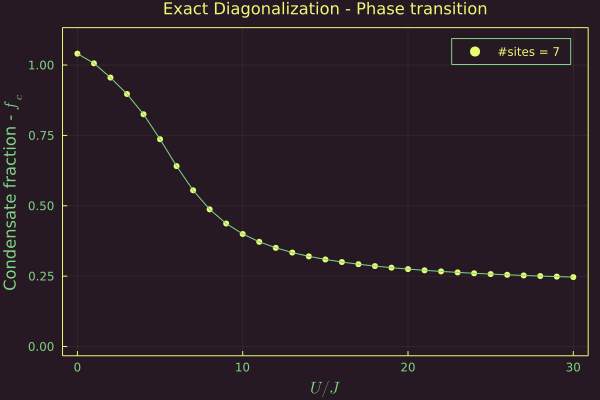

In [201]:
plot(U, fc ./ num_states, st = [:scatter, :line], labels = ["#sites = 7" ""], xlabel = L"$U/J$", ylabel = L"Condensate fraction - $f_c$")
p1 = plot!(framestyle = :box, title = "Exact Diagonalization - Phase transition", titlefontsize = 11, ylims = [0., 1.1])

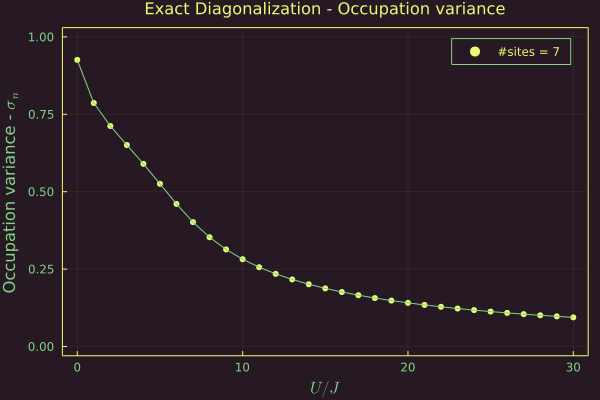

In [202]:
plot(U, nvar, st = [:scatter, :line], labels = ["#sites = 7" ""], xlabel = L"$U/J$", ylabel = L"Occupation variance - $\sigma_n$")
p2 = plot!(framestyle = :box, title = "Exact Diagonalization - Occupation variance", titlefontsize = 11, ylims = [0., 1.0])